#Download dataset

##linux

In [ ]:
!rm -rf *
!git clone "https://github.com/hmda77/Ensemble-Indoor-Loc"
!cp /content/Ensemble-Indoor-Loc/JUIndoorLoc/JUIndoorLoc-Test-data.csv /content/
!cp /content/Ensemble-Indoor-Loc/JUIndoorLoc/JUIndoorLoc-Training-data.csv /content/
!rm -rf /content/Ensemble-Indoor-Loc/

'rm' is not recognized as an internal or external command,
operable program or batch file.
Cloning into 'Ensemble-Indoor-Loc'...
fatal: unable to access 'https://github.com/hmda77/Ensemble-Indoor-Loc/': Recv failure: Connection was reset
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


# Import Packages

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder , normalize
from itertools import cycle

import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from matplotlib import pyplot

# Metric Functions


In [ ]:

# Make the confusion matrix
def confusion_plot(y_test,y_pred,title):
    cmt = confusion_matrix(y_test,y_pred)
    plt.rcParams['figure.figsize'] = (10,8)
    sns.heatmap(cmt,fmt='',annot=True,linewidth=0.01,cmap=sns.cubehelix_palette(as_cmap=True))
    plt.title("confusion matrix {}".format(title))
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.show()


# generate classification report
def generate_classification_report(y_test,y_pred):
    report=pd.DataFrame.from_dict(classification_report(y_pred,y_test,output_dict=True)).T
    # report['Label']=[data_classes[i]  if i<5 else " " for i,x in enumerate(report.index)]
    report=report[['f1-score','precision','recall','support']]
    pd.set_option('display.max_rows', report.shape[0]+1)
    return report

# ROC Curve
def plot_roc_curve(y_test,proba,pos_label):
    fpr, tpr, thresholds = roc_curve(y_test, proba[:,pos_label], pos_label= pos_label)
    roc_auc = roc_auc_score(y_test, proba, multi_class='ovr')

    plt.rcParams['figure.figsize'] = (5,4)
    plt.plot(fpr, tpr,'k:',lw=5, label='average ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0 ,1],[0 ,1],'r')
    plt.legend(loc="lower right")
    # plt.title('ROC Curve for calss {0}'.format(data_classes[pos_label]))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


# ROC Curve for all classes
def plot_roc_curve_all(y_test,proba,n_class,title):
    for i in range(n_class):
      fpr, tpr, thresholds = roc_curve(y_test, proba[:,i],pos_label= i)
      plt.plot(fpr, tpr,lw=1)
    plt.plot([0 ,1],[0 ,1],'r')
    plt.title('ROC Curve for all classes in {}'.format(title))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    # plt.legend(data_classes)
    plt.show()

#Dateset Proccesses

In [ ]:
data_train = pd.read_csv("C:\\Users\Hamid\content\JUIndoorLoc-Training-data.csv")
data_train.head(5)

<>:1: SyntaxWarning: invalid escape sequence '\H'
<>:1: SyntaxWarning: invalid escape sequence '\H'
C:\Users\Hamid\AppData\Local\Temp\ipykernel_13132\1745947030.py:1: SyntaxWarning: invalid escape sequence '\H'
  data_train = pd.read_csv("C:\\Users\Hamid\content\JUIndoorLoc-Training-data.csv")


,Cid,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,...,AP167,AP168,AP169,AP170,AP171,AP172,Rs,Hpr,Did,Ts
0,L4-40-1,-84,-80,-71,-58,-110,-72,-71,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1469870570949
1,L4-40-1,-84,-79,-71,-58,-110,-72,-71,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1470047205646
2,L4-40-1,-110,-110,-70,-56,-110,-69,-68,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1469870932338
3,L4-40-1,-110,-110,-70,-53,-110,-69,-68,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1470047629440
4,L4-37-2,-84,-82,-75,-65,-110,-73,-75,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1469876622694


In [ ]:
data_train['Did'] = data_train['Did'].astype(str).str[1]
data_train['Did'] = pd.to_numeric(data_train['Did'])

In [ ]:
data_test = pd.read_csv("C:\\Users\Hamid\content\JUIndoorLoc-Test-data.csv")
data_test.head(5)

<>:1: SyntaxWarning: invalid escape sequence '\H'
<>:1: SyntaxWarning: invalid escape sequence '\H'
C:\Users\Hamid\AppData\Local\Temp\ipykernel_13132\2397508738.py:1: SyntaxWarning: invalid escape sequence '\H'
  data_test = pd.read_csv("C:\\Users\Hamid\content\JUIndoorLoc-Test-data.csv")


,Cid,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,...,AP167,AP168,AP169,AP170,AP171,AP172,Rs,Hpr,Did,Ts
0,L4-33-13,-77,-58,-66,-64,-92,-66,-66,-93,-93,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489813137748
1,L4-33-13,-90,-58,-78,-56,-92,-74,-74,-87,-93,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489813179138
2,L4-33-13,-80,-64,-78,-56,-92,-74,-74,-87,-93,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489812948443
3,L4-33-13,-72,-60,-74,-58,-93,-75,-76,-95,-93,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489812959103
4,L4-33-13,-82,-56,-74,-56,-93,-71,-76,-89,-110,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489813079167


In [ ]:
data_test['Did'] = data_test['Did'].astype(str).str[1]
data_test['Did'] = pd.to_numeric(data_test['Did'])

In [ ]:
#make X_train from Tr
X = normalize(data_train.loc[:, (data_train.columns != 'Ts') & (data_train.columns != 'Cid')])
y = data_train.Cid

Xt = normalize(data_test.loc[:, (data_train.columns != 'Ts') & (data_train.columns != 'Cid')])
yt = data_test.Cid

le = LabelEncoder()
le.fit(y)
le.transform(y)


X_train = X
y_train_encode =  le.transform(y)

X_test = Xt
y_test_encode = le.transform(yt)

In [ ]:
print(len(np.unique(y_train_encode)))
print(len(y.unique()))

991
991


# XGBoost Classification

In [ ]:
# model = XGBClassifier(device = "cuda", n_estimators = 100, max_depth = 3, subsample = 0.3, colsample_bytree=0.1, gamma = 100, eta=0.3)
# model = XGBClassifier(device = "cuda",  n_estimators = 1000, max_depth = 10, subsample = 0.5, colsample_bytree=0.001, eta=0.01)

model = XGBClassifier(device = "cuda")
# eval_set = [(X_train, y_train_encode), (X_test, y_test_encode)]
model.fit(X_train, y_train_encode, early_stopping_rounds=10, eval_metric=["merror","mlogloss"], eval_set= eval_set, verbose=True)

# #make model
# # c = KNeighborsClassifier(n_neighbors=5)
# c = XGBClassifier()
# # Prediction Y_pred
# define 10 Fold Cross Validation
# cv = KFold(n_splits=10, random_state=42, shuffle=True)
# y_pred = cross_val_predict(model, X_train, y_train_encode, cv=cv, n_jobs = 1, method = 'predict')

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-merror:0.92864	validation_0-mlogloss:4.52540	validation_1-merror:0.92833	validation_1-mlogloss:4.53918
[1]	validation_0-merror:0.55451	validation_0-mlogloss:2.89663	validation_1-merror:0.56386	validation_1-mlogloss:2.91531
[2]	validation_0-merror:0.28490	validation_0-mlogloss:2.00226	validation_1-merror:0.29085	validation_1-mlogloss:2.01840
[3]	validation_0-merror:0.16316	validation_0-mlogloss:1.46878	validation_1-merror:0.16481	validation_1-mlogloss:1.48095
[4]	validation_0-merror:0.10011	validation_0-mlogloss:1.10267	validation_1-merror:0.09774	validation_1-mlogloss:1.10922
[5]	validation_0-merror:0.06389	validation_0-mlogloss:0.84647	validation_1-merror:0.06009	validation_1-mlogloss:0.84804
[6]	validation_0-merror:0.04154	validation_0-mlogloss:0.66151	validation_1-merror:0.03793	validation_1-mlogloss:0.66101
[7]	validation_0-merror:0.02701	validation_0-mlogloss:0.52484	validation_1-merror:0.02482	validation_1-mlogloss:0.52326
[8]	validation_0-merror:0.01889	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

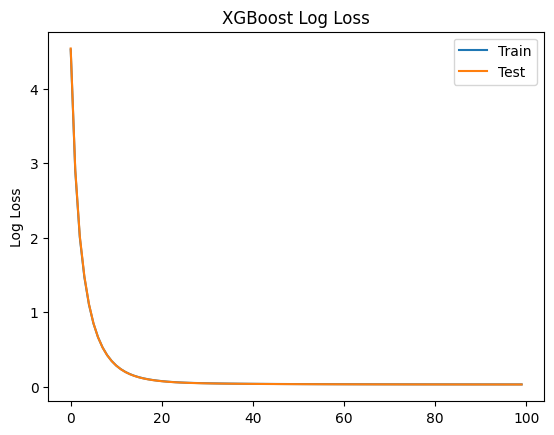

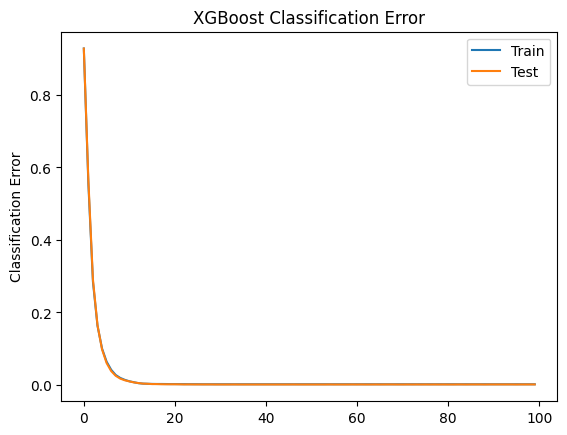

In [ ]:
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [ ]:
model = XGBClassifier(device = "cuda", n_estimators = 40)
eval_set = [(X_train, y_train_encode), (X_test, y_test_encode)]
model.fit(X_train, y_train_encode, early_stopping_rounds=10, eval_metric=["merror","mlogloss"], eval_set= eval_set, verbose=True)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-merror:0.92855	validation_0-mlogloss:4.52954	validation_1-merror:0.87603	validation_1-mlogloss:3.83964
[1]	validation_0-merror:0.55731	validation_0-mlogloss:2.90224	validation_1-merror:0.56781	validation_1-mlogloss:2.54611
[2]	validation_0-merror:0.28669	validation_0-mlogloss:2.00710	validation_1-merror:0.34041	validation_1-mlogloss:1.91482
[3]	validation_0-merror:0.16365	validation_0-mlogloss:1.47243	validation_1-merror:0.26301	validation_1-mlogloss:1.60850
[4]	validation_0-merror:0.09940	validation_0-mlogloss:1.10464	validation_1-merror:0.22534	validation_1-mlogloss:1.40030
[5]	validation_0-merror:0.06275	validation_0-mlogloss:0.84694	validation_1-merror:0.21370	validation_1-mlogloss:1.25855
[6]	validation_0-merror:0.04045	validation_0-mlogloss:0.66136	validation_1-merror:0.20342	validation_1-mlogloss:1.13831
[7]	validation_0-merror:0.02636	validation_0-mlogloss:0.52437	validation_1-merror:0.18836	validation_1-mlogloss:1.03634
[8]	validation_0-merror:0.01832	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=40, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred_encode = model.predict(X_test)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:51:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
generate_classification_report(y_test_encode, y_pred_encode)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,f1-score,precision,recall,support
492,0.000000,0.000000,0.000000,4.00000
545,0.000000,0.000000,0.000000,3.00000
627,0.000000,0.000000,0.000000,1.00000
630,0.923077,1.000000,0.857143,28.00000
631,1.000000,1.000000,1.000000,24.00000
632,1.000000,1.000000,1.000000,24.00000
633,1.000000,1.000000,1.000000,24.00000
634,1.000000,1.000000,1.000000,24.00000
635,0.857143,0.750000,1.000000,18.00000
636,1.000000,1.000000,1.000000,27.00000


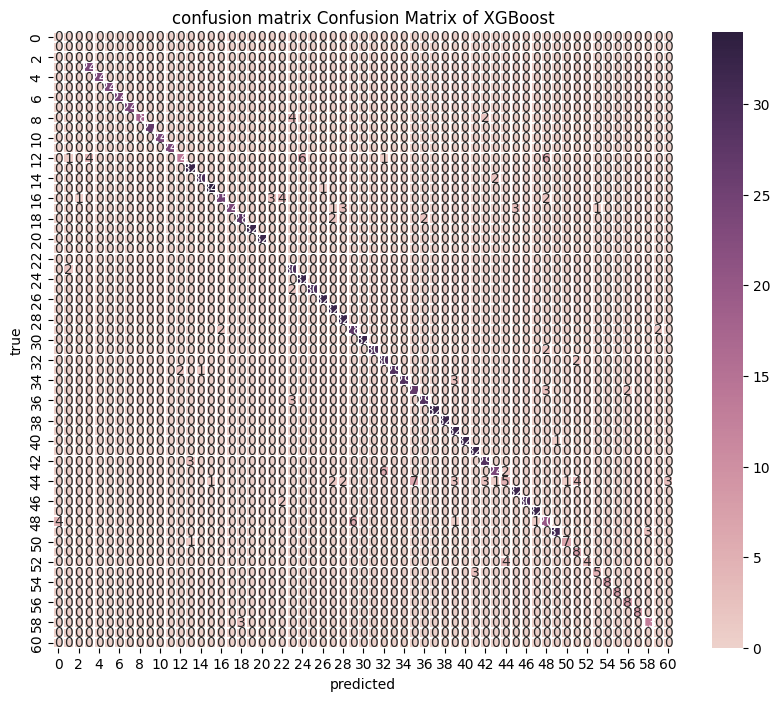

In [ ]:
confusion_plot(y_test_encode, y_pred_encode,"Confusion Matrix of XGBoost")

# Adaboost Model

In [ ]:
# Create an AdaBoostClassifier
adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)

# Fit the model
adaboost.fit(X_train, y_train_encode)

AdaBoostClassifier(random_state=42)

In [ ]:
# Make predictions on the test set
y_pred = adaboost.predict(X_test)



In [ ]:
generate_classification_report(y_test_encode, y_pred)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

,f1-score,precision,recall,support
630,0.000000,0.000000,0.000000,0.000000
631,1.000000,1.000000,1.000000,24.000000
632,0.000000,0.000000,0.000000,0.000000
633,0.000000,0.000000,0.000000,0.000000
634,0.000000,0.000000,0.000000,0.000000
635,0.000000,0.000000,0.000000,0.000000
636,0.000000,0.000000,0.000000,0.000000
638,0.000000,0.000000,0.000000,0.000000
639,0.000000,0.000000,0.000000,0.000000
651,0.000000,0.000000,0.000000,0.000000
